Classes: ['benign', 'malignant', 'normal']


,Class,Count
0,benign,437
1,malignant,210
2,normal,133


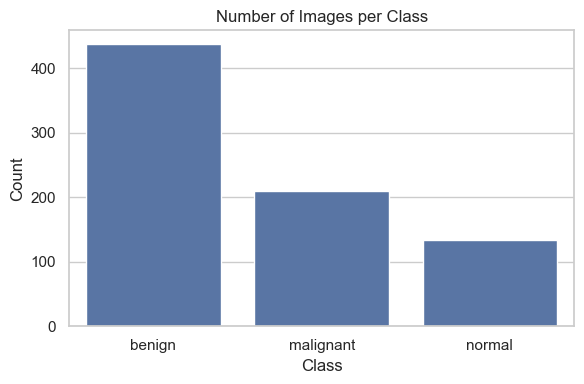

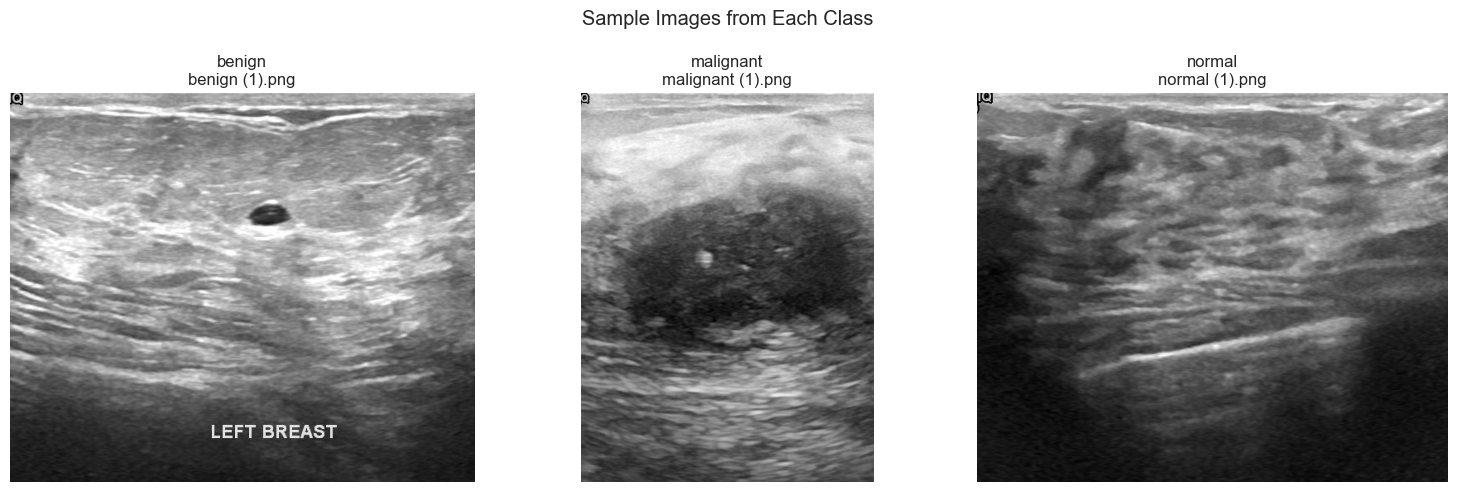

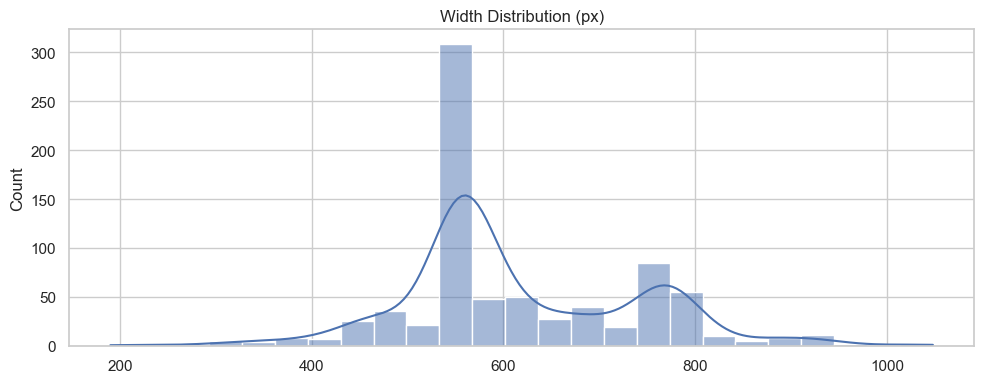

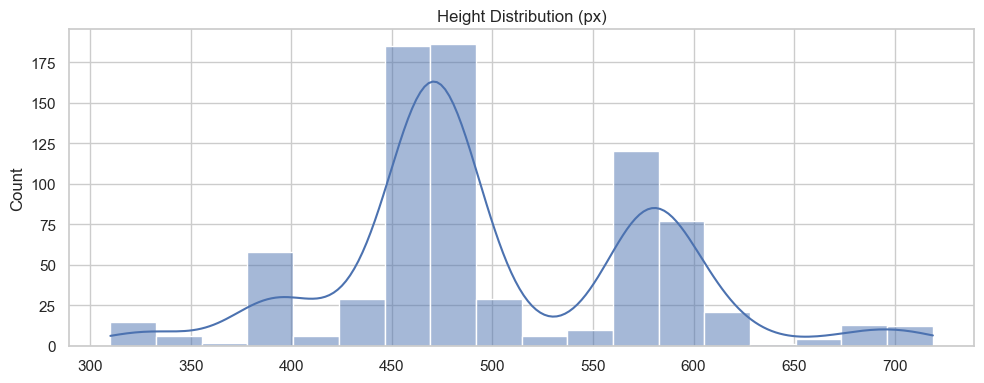

Average size: 615.7 × 501.5 px


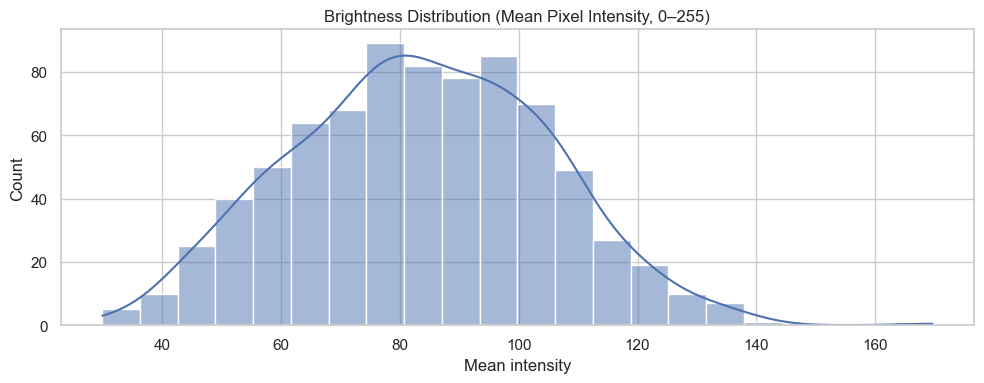

Avg brightness (overall): 83.63


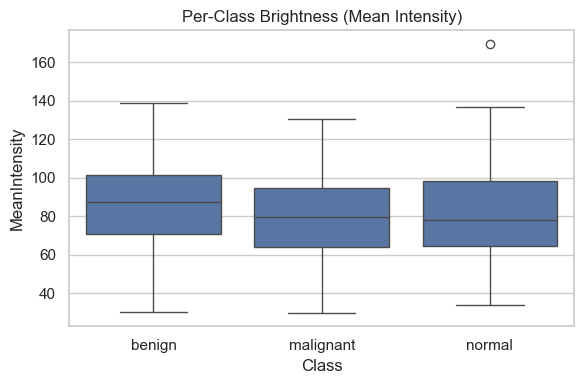

Corrupted files: 0
Average BGR: (132.38, 132.38, 132.38)


In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

data_dir = Path("Dataset_BUSI_with_GT")
valid_ext = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def list_images(folder: Path):
    return [
        p for p in folder.iterdir()
        if p.is_file()
        and (p.suffix.lower() in valid_ext)
        and not p.name.startswith(".")
        and "mask" not in p.stem.lower()
    ]

classes = [c for c in os.listdir(data_dir) if not c.startswith(".") and (data_dir/c).is_dir()]
print("Classes:", classes)

# 1) Counts
image_counts = {cls: len(list_images(data_dir/cls)) for cls in classes}
display(pd.DataFrame(image_counts.items(), columns=["Class", "Count"]).sort_values("Class"))

plt.figure(figsize=(6,4))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title("Number of Images per Class")
plt.xlabel("Class"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# 2) Sample images (one per class)
fig, axes = plt.subplots(1, len(classes), figsize=(5*len(classes), 5))
if len(classes) == 1: axes = [axes]
for ax, cls in zip(axes, classes):
    imgs = list_images(data_dir/cls)
    if not imgs:
        ax.text(0.5, 0.5, "No images", ha="center", va="center")
        ax.set_title(cls); ax.axis("off"); continue
    im = Image.open(imgs[0])
    ax.imshow(im if im.mode=="RGB" else np.array(im), cmap=None if im.mode=="RGB" else "gray")
    ax.set_title(f"{cls}\n{imgs[0].name}"); ax.axis("off")
plt.suptitle("Sample Images from Each Class"); plt.tight_layout(); plt.show()

# 3) Dimension distributions
widths, heights = [], []
for cls in classes:
    for p in list_images(data_dir/cls):
        try:
            im = Image.open(p)
            widths.append(im.width); heights.append(im.height)
        except UnidentifiedImageError:
            pass

plt.figure(figsize=(10,4)); sns.histplot(widths, kde=True)
plt.title("Width Distribution (px)"); plt.tight_layout(); plt.show()
plt.figure(figsize=(10,4)); sns.histplot(heights, kde=True)
plt.title("Height Distribution (px)"); plt.tight_layout(); plt.show()
print(f"Average size: {np.mean(widths):.1f} × {np.mean(heights):.1f} px")

# 4) Brightness
def mean_gray(p: Path):
    a = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    return None if a is None else float(a.mean())

brightness_all, brightness_by_class = [], {}
for cls in classes:
    vals = [m for m in (mean_gray(p) for p in list_images(data_dir/cls)) if m is not None]
    brightness_by_class[cls] = vals
    brightness_all.extend(vals)

plt.figure(figsize=(10,4)); sns.histplot(brightness_all, kde=True)
plt.title("Brightness Distribution (Mean Pixel Intensity, 0–255)")
plt.xlabel("Mean intensity"); plt.tight_layout(); plt.show()
print(f"Avg brightness (overall): {np.mean(brightness_all):.2f}")

# Per-class boxplot
df_b = (pd.DataFrame([(cls, v) for cls, arr in brightness_by_class.items() for v in arr],
                     columns=["Class","MeanIntensity"]))
plt.figure(figsize=(6,4)); sns.boxplot(data=df_b, x="Class", y="MeanIntensity")
plt.title("Per-Class Brightness (Mean Intensity)"); plt.tight_layout(); plt.show()

# 5) Corrupted/non-image files check
bad_files = []
for cls in classes:
    for p in list_images(data_dir/cls):
        try:
            Image.open(p).verify()
        except Exception:
            bad_files.append(p)
print("Corrupted files:", len(bad_files))

# 6) Average BGR
first_ok = None
for cls in classes:
    imgs = list_images(data_dir/cls)
    if imgs:
        first_ok = imgs[0]; break
if first_ok:
    arr = cv2.imread(str(first_ok))
    if arr is not None:
        b,g,r = cv2.mean(arr)[:3]
        print(f"Average BGR: ({b:.2f}, {g:.2f}, {r:.2f})")
